<a href="https://colab.research.google.com/github/tshabalalasibongile/Geostatistical-Interpolation/blob/main/week4_interpolation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sibongile Tshabalala (2356121)

Week 4 Homework:  Interpolation for Cu% (IDW, SK, OK)

In [ ]:
!pip install pykrige

In [ ]:
!pip install gstools

In [ ]:
!pip install scikit-gstat

# 1. Data & Week 3 Foundations (rerun for continuity)

# 1.1 Load Data

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pykrige.ok import OrdinaryKriging
import gstools as gs
from skgstat import Variogram
from shapely.geometry import Point
import geopandas as gpd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import warnings
warnings.filterwarnings('ignore')


In [ ]:
#loading the dataset
df = pd.read_csv('CuMineBH.csv')

#normalize columns names
df.columns = [c.strip() for c in df.columns]

possible_e = [c for c in df.columns if c.lower() in ('east','e','easting')]
possible_n = [c for c in df.columns if c.lower() in ('north','n','northing')]
possible_cu = [c for c in df.columns if 'cu' in c.lower()]

east_col = possible_e[0]
north_col = possible_n[0]
cu_col = possible_cu[0]

df = df[[east_col, north_col, cu_col]].dropna().rename(columns={east_col:'EAST', north_col:'NORTH', cu_col:'Cu'}).reset_index(drop=True)


In [ ]:
#showing head
df.head()


,EAST,NORTH,Cu
0,56.122424,105.841818,0.750
1,74.176970,81.483939,0.664
2,140.032424,191.491515,0.202
3,158.912121,133.599697,0.408
4,50.455455,211.942121,0.602


In [ ]:
#showing summary
df.describe()

,EAST,NORTH,Cu
count,1575.000000,1575.000000,1575.000000
mean,255.912312,155.871652,0.405832
std,158.598035,63.364120,0.230091
min,0.000000,0.000000,0.026000
25%,119.457424,113.178939,0.244000
50%,237.761515,163.326061,0.356000
75%,401.520303,207.209848,0.522000
max,561.063636,268.143939,1.968000


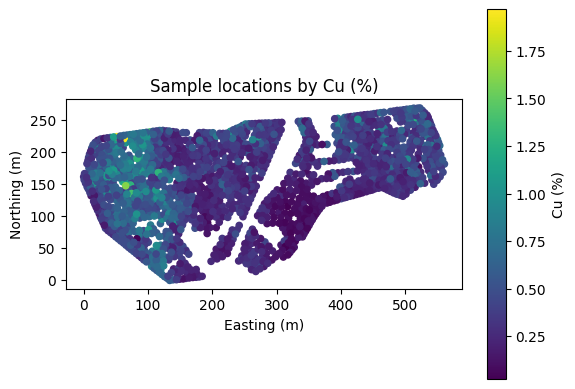

In [ ]:
#scatter plot
plt.scatter(df['EAST'], df['NORTH'], c=df['Cu'], cmap = 'viridis', s=20)
plt.colorbar(label='Cu (%)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Sample locations by Cu (%)')
plt.gca().set_aspect('equal', 'box')
plt.show()

# 1.2 Declustering recap

Suggested cell size (2 * mean NND) = **12.89m**
Naive Mean = 0.4058, Naive std = 0.2301, Naive variance = 0.0529
Declustered Mean = 0.3922, Declustered std = 0.2262, Declustered variance = 0.0512


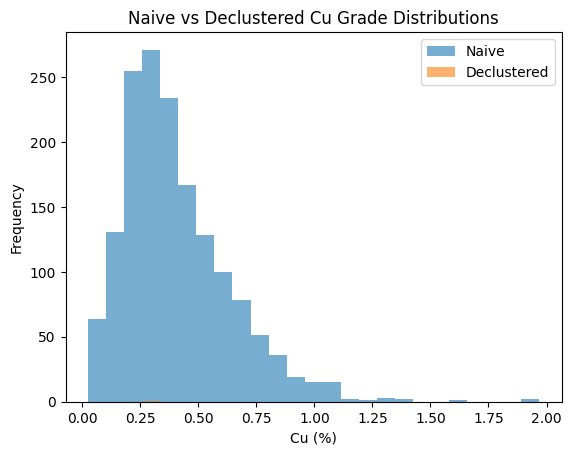

In [ ]:
#Suggesting cell size
from scipy.spatial import distance
from statsmodels.stats.weightstats import DescrStatsW

coords = df[['EAST', 'NORTH']].values
D = distance.cdist(coords, coords)
np.fill_diagonal(D, np.nan)
nnd = np.nanmin(D, axis=1)
mean_nnd = np.nanmean(nnd)
cell_size_suggest = 2 * mean_nnd
print(f"Suggested cell size (2 * mean NND) = **{cell_size_suggest:.2f}m**")

#Use suggested cell size
cell_size = cell_size_suggest if cell_size_suggest > 0 else 50

df['ix'] = np.floor((df['EAST'] - df['EAST'].min()) / cell_size).astype(int)
df['iy'] = np.floor((df['NORTH'] - df['NORTH'].min()) / cell_size).astype(int)

cell_counts = df.groupby(['ix', 'iy']).size().reset_index(name='count')
df = df.merge(cell_counts, on=['ix', 'iy'], how='left')

df['weight'] = 1.0 / df['count']
df['weight'] = df['weight'] / df['weight'].sum()

#Naive statistics
naive_mean = float(df['Cu'].mean())
naive_var = float(df['Cu'].var(ddof=1))
naive_std = float(df['Cu'].std(ddof=1))

#Declustered (weighted) statistics
decl_stats = DescrStatsW(df['Cu'], weights=df['weight'], ddof=0)
decl_mean = float(decl_stats.mean)
decl_var = float(decl_stats.var)
decl_std = float(decl_stats.std)


print(f"Naive Mean = {naive_mean:.4f}, Naive std = {naive_std:.4f}, Naive variance = {naive_var:.4f}")
print(f"Declustered Mean = {decl_mean:.4f}, Declustered std = {decl_std:.4f}, Declustered variance = {decl_var:.4f}")

plt.figure()
plt.hist(df['Cu'], bins=25, alpha=0.6, label='Naive')
plt.hist(df['Cu'], bins=25, weights=df['weight'], alpha=0.6, label='Declustered')
plt.legend()
plt.title('Naive vs Declustered Cu Grade Distributions')
plt.xlabel('Cu (%)')
plt.ylabel('Frequency')
plt.show()

# 1.3 Normal Score Transform (NST)

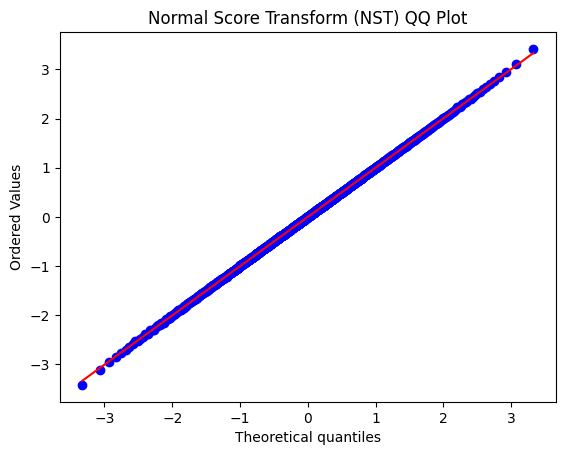

'NST mean ~ 0.000, std ~ 1.000'

In [ ]:
from scipy.stats import rankdata, norm, probplot
from scipy.interpolate import interp1d

vals = df['Cu'].values
ranks = rankdata(vals, method='average')
p_plot = (ranks - 0.5) / len(vals)
ns_vals = norm.ppf(p_plot)
df['ns_Cu'] = ns_vals

#forward/backward interpolation maps
sort_idx = np.argsort(vals)
emp_sorted = vals[sort_idx]
ns_sorted = ns_vals[sort_idx]

forward_interp = interp1d(emp_sorted, ns_sorted, bounds_error=False, fill_value=(ns_sorted[0], ns_sorted[-1]))
backward_interp = interp1d(ns_sorted, emp_sorted, bounds_error=False, fill_value=(emp_sorted[0], emp_sorted[-1]))

#QQ plot
plt.figure()
probplot(df['ns_Cu'], dist='norm', plot=plt)
plt.title('Normal Score Transform (NST) QQ Plot')
plt.show()

display(f"NST mean ~ {df['ns_Cu'].mean():.3f}, std ~ {df['ns_Cu'].std():.3f}")


# 1.4 Variogram recap & model selection

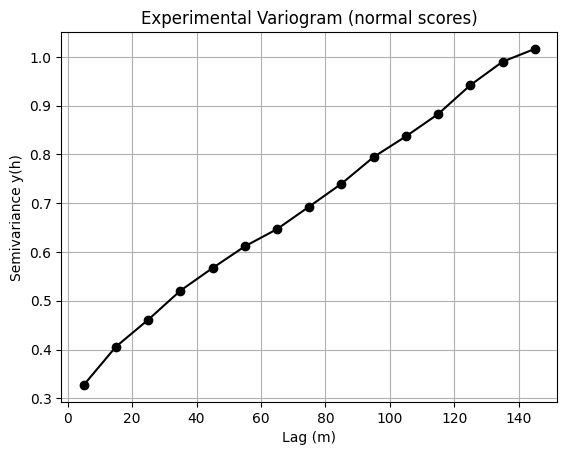

'Pairs per lag (mid lag, semivariance, pairs)'

,Lag_mid,Semivariance,Pairs
0,5.0,0.327390,4123
1,15.0,0.405969,10729
2,25.0,0.461067,18147
3,35.0,0.520711,22699
4,45.0,0.567155,27835
5,55.0,0.611467,31032
6,65.0,0.646841,35277
7,75.0,0.693058,37282
8,85.0,0.739883,39635
9,95.0,0.794692,41633


' Variogram model fits (sorted by RMSE)'

,Model,Nugget,Sill,Range,RMSE
0,Spherical,0.326384,1.519468,352.477348,0.010730
1,Exponential,0.297396,1.859219,725.000000,0.014073
2,Gaussian,0.400263,1.074710,169.910907,0.028465


'Chosen model: Spherical (nugget=0.3264, sill=1.5195, range=352.48)'

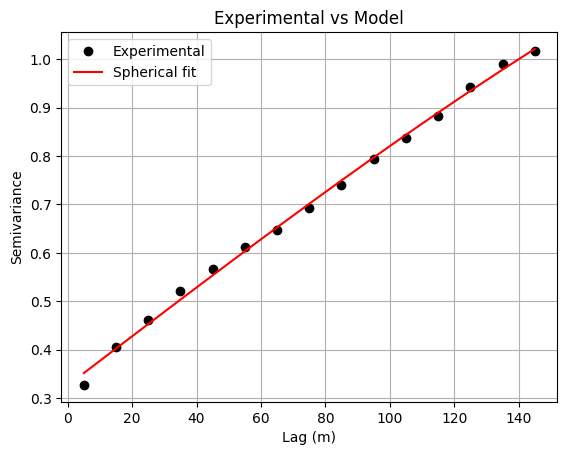

In [ ]:
def experimental_variogram(coords, values, lags, n_lags):
  N = len(values)
  pdists = distance.pdist(coords)
  iu = np.triu_indices(N, k=1)
  dists = distance.squareform(pdists)[iu]
  diffs = (np.subtract.outer(values, values)**2)[iu]
  hs, gamma, pair_counts = [], [], []
  for i in range(1, n_lags+1):
    lower = (i-1)*lag
    upper = i*lag
    mask = (dists > lower) & (dists <= upper)
    pair_counts.append(np.sum(mask))
    if np.any(mask):
      hs.append((lower+upper)/2)
      gamma.append(0.5 * np.mean(diffs[mask]))
    else:
      gamma.append(np.nan)
      hs.append((lower+upper)/2)
  return np.array(hs), np.array(gamma), np.array(pair_counts)

lag = max(int(mean_nnd), 10)
n_lags = 15
coords_arr = df[['EAST', 'NORTH']].values
hs, gamma, pair_counts = experimental_variogram(coords_arr, df['ns_Cu'].values, lag, n_lags)

#Plot experimental variogram
plt.plot(hs, gamma, 'ko-')
plt.xlabel('Lag (m)')
plt.ylabel('Semivariance y(h)')
plt.title('Experimental Variogram (normal scores)')
plt.grid()
plt.show()

#pairs-per-lag table
pairs_table = pd.DataFrame({'Lag_mid': hs, 'Semivariance': gamma, 'Pairs': pair_counts})
display("Pairs per lag (mid lag, semivariance, pairs)")
display(pairs_table)

#Fit models
def spherical(h, nug, sill, rng):
  h = np.array(h)
  return np.where(h <= rng, nug + (sill - nug)*(1.5*(h/rng) - 0.5*(h/rng)**3), sill)

def exponential(h, nug, sill, rng):
  h = np.array(h)
  return nug + (sill - nug) * (1 - np.exp(-3*h/rng))

def gaussian(h, nug, sill, rng):
  h = np.array(h)
  return nug + (sill - nug) * (1 - np.exp(-3*(h**2)/(rng**2)))

models ={'Spherical': spherical, 'Exponential': exponential, 'Gaussian': gaussian}
fit_results = []
h_nonan = h[~np.isnan(gamma)]
gamma_nonan = gamma[~np.isnan(gamma)]

for name, func in models.items():
  try:
    p0 = [0.01*np.nanmax(gamma_nonan), np.nanmax(gamma_nonan), np.max(h_nonan) or lag]
    upper = [np.nanmax(gamma_nonan)*2, np.nanmax(gamma_nonan)*5, np.max(h_nonan)*5 if len(h_nonan)>0 else lag*5]
    popt, _ = curve_fit(func, h_nonan, gamma_nonan, p0=p0, bounds=([0,0,1e-6], upper), maxfev=10000)
    nug, sill, rng = popt
    fit = func(h_nonan, *popt)
    rmse = np.sqrt(np.mean((gamma_nonan - fit)**2))
    fit_results.append((name, float(nug), float(sill), float(rng), float(rmse)))
  except Exception as e:
    print(f"{name} fit failed: {e}")

fit_table = pd.DataFrame(fit_results, columns=['Model','Nugget','Sill','Range','RMSE']).sort_values('RMSE')
display(" Variogram model fits (sorted by RMSE)")
display(fit_table)

if not fit_table.empty:
  chosen = fit_table.iloc[0]
  chosen_model_name = chosen['Model']
  nugget, sill, vrange = chosen['Nugget'], chosen['Sill'], chosen['Range']
  display(f"Chosen model: {chosen_model_name} (nugget={nugget:.4f}, sill={sill:.4f}, range={vrange:.2f})")
else:
  chosen_model_name = 'Spherical'
  nugget, sill, vrange = 0.0, np.nanvar(df['ns_Cu']), mean_nnd*5
  display("No fit succeeded; using fallback variogram parameters.")

#plot experimental vs chosen model
if chosen_model_name is not None:
  plt.plot(hs, gamma, 'ko', label='Experimental')
  plt.plot(h_nonan, models[chosen_model_name](h_nonan, nugget, sill, vrange), 'r-', label=f"{chosen_model_name} fit")
  plt.xlabel('Lag (m)')
  plt.ylabel('Semivariance')
  plt.legend()
  plt.title('Experimental vs Model')
  plt.grid()
  plt.show()

  #convert to gstools model
  con_var = max(0.0, sill - nugget)
  con_len_scale = vrange
  if chosen_model_name == 'Spherical':
    gs_model = gs.Spherical(dim=2, var=con_var, len_scale=con_len_scale, nugget=nugget)
  elif chosen_model_name == 'Exponential':
    gs_model = gs.Exponential(dim=2, var=con_var, len_scale=con_len_scale, nugget=nugget)
  else:
    gs_model = gs.Gaussian(dim=2, var=con_var, len_scale=con_len_scale, nugget=nugget)



# 2. Interpolation Grid & Search Strategy

In [ ]:
grid_spacing = 10.0
Emin, Emax = df['EAST'].min(), df['EAST'].max()
Nmin, Nmax = df['NORTH'].min(), df['NORTH'].max()
pad = grid_spacing * 2
xs = np.arange(Emin - pad, Emax + pad + 1e-6, grid_spacing)
ys = np.arange(Nmin - pad, Nmax + pad + 1e-6, grid_spacing)
xx, yy = np.meshgrid(xs, ys)
grid_points = np.c_[xx.ravel(), yy.ravel()]
display(f"Grid spacing = {grid_spacing}m, grid shape = {len(ys)} x {len(xs)}")

search_radius = 1.25 * vrange
min_neighbors = 3
max_neighbors = 16
display(f"Search radius = {search_radius:.2f}m (1.25xrange), min neighbors = {min_neighbors}, max neighbors = {max_neighbors}")

'Grid spacing = 10.0m, grid shape = 31 x 61'

'Search radius = 440.60m (1.25xrange), min neighbors = 3, max neighbors = 16'

# 3. IDW Interpolation (p = 1, 2, 3, 4, 5)

Computing IDW p=1
Computing IDW p=2
Computing IDW p=3
Computing IDW p=4
Computing IDW p=5


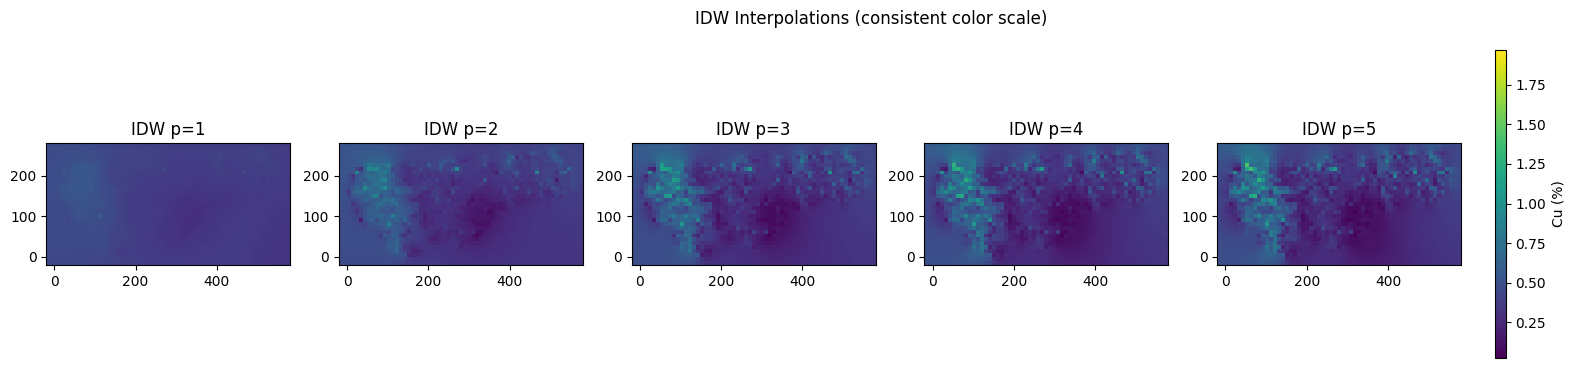

In [ ]:
from scipy.spatial import cKDTree

def idw_predict(points, values, xi, power=2, radius=np.inf, k=None):
  tree = cKDTree(points)
  if np.isfinite(radius):
    neighbors = tree.query_ball_point(xi, r=radius)
    preds = np.full(len(xi), np.nan)
    for i, nbr in enumerate(neighbors):
      if len(nbr) == 0:
        continue
      d = np.linalg.norm(points[nbr] - xi[i], axis=1)
      if np.any(d == 0):
        preds[i] = values[nbr][np.argmin(d)]
        continue
      w = 1.0 / (d**power)
      preds[i] = np.sum(w * values[nbr]) / np.sum(w)
    return preds
  else:
    if k is None:
      k = len(points)
    dists, idx = tree.query(xi, k=k)
    if k == 1:
      dists = dists.reshape(-1,1); idx = idx.reshape(-1,1)
    preds = np.full(len(xi), np.nan)
    for i in range(len(xi)):
      d = dists[i]; ids = idx[i]
      if np.any(d == 0):
        preds[i] = values[ids[np.argmin(d)]]
        continue
      w = 1.0 / (d**power)
      preds[i] = np.sum(w * values[ids]) / np.sum(w)
    return preds

points = df[['EAST','NORTH']].values
values = df['Cu'].values

idw_maps = {}
for p in [1,2,3,4,5]:
  print(f"Computing IDW p={p}")
  idw_maps[p] = idw_predict(points, values, grid_points, power=p, radius=search_radius, k=max_neighbors)

#Plot IDW maps
vmin, vmax = values.min(), values.max()
fig, axs = plt.subplots(1, 5, figsize=(22, 4))
for ax, p in zip(axs, [1,2,3,4,5]):
  im = ax.imshow(idw_maps[p].reshape(len(ys), len(xs)), origin='lower',
                 extent=(xs.min(), xs.max(), ys.min(), ys.max()),
                 vmin=vmin, vmax=vmax, cmap='viridis')
  ax.set_title(f'IDW p={p}')
plt.suptitle('IDW Interpolations (consistent color scale)')
cbar = fig.colorbar(im, ax=axs.tolist(), shrink=1.0, pad=0.02, aspect=30)
cbar.set_label('Cu (%)')
plt.show()

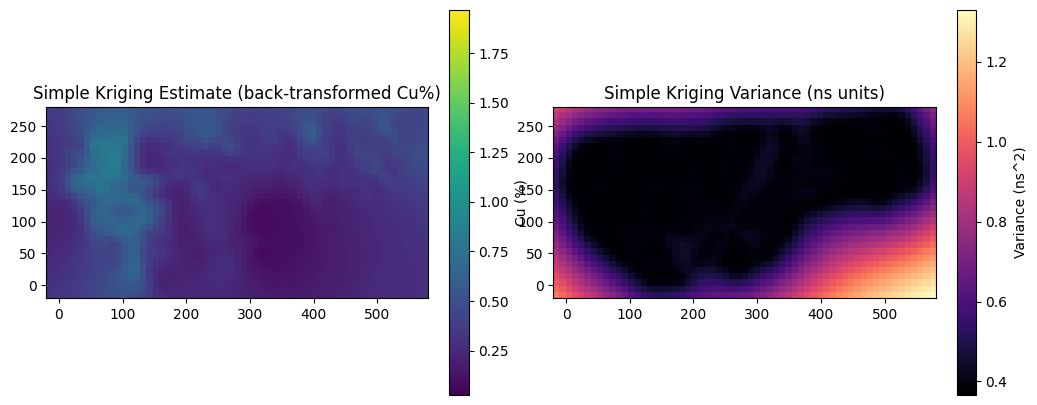

In [ ]:
#Simple Kriging (SK) on normal scores with gstools, then back-transform
try:
  srf = gs.krige.Simple(gs_model, cond_pos=coords_arr.T, cond_val=df['ns_Cu'].values, mean=df['ns_Cu'].mean())
  sk_field, sk_var = srf((xx.ravel(), yy.ravel()), return_var=True)
  sk_field = np.array(sk_field).reshape(xx.shape)
  sk_var = np.array(sk_var).reshape(xx.shape)

  #back transform: use backward_interp on ns values
  sk_bt = backward_interp(sk_field.ravel()).reshape(sk_field.shape)
  fig, ax = plt.subplots(1,2,figsize=(12,5))
  im0 = ax[0].imshow(sk_bt, origin='lower', extent=(xs.min(), xs.max(), ys.min(), ys.max()), vmin=vmin, vmax=vmax, cmap='viridis')
  ax[0].set_title('Simple Kriging Estimate (back-transformed Cu%)')
  im1 = ax[1].imshow(sk_var, origin='lower', extent=(xs.min(), xs.max(), ys.min(), ys.max()), cmap='magma')
  ax[1].set_title('Simple Kriging Variance (ns units)')
  fig.colorbar(im0, ax=ax[0], fraction=0.046).set_label('Cu (%)')
  fig.colorbar(im1, ax=ax[1], fraction=0.046).set_label('Variance (ns^2)')
  plt.show()
except Exception as e:
  print(f"Simple Kriging failed: {e}")
  sk_bt = None
  sk_var = None

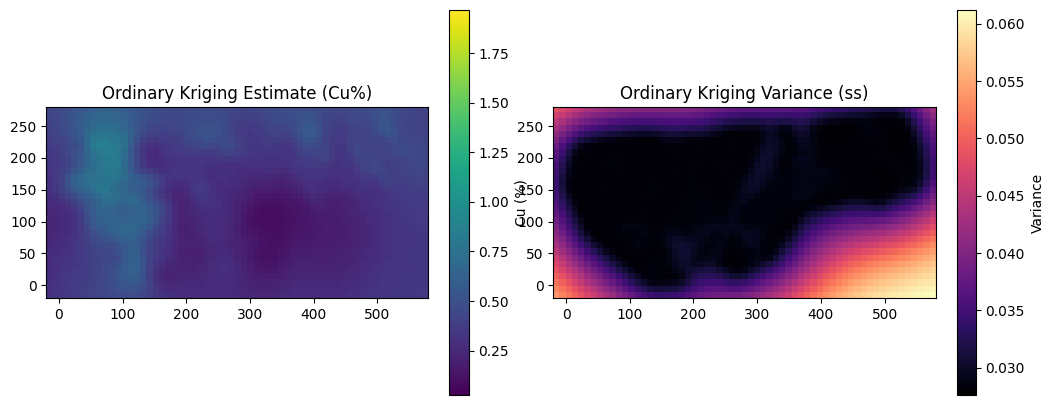

In [ ]:
#Ordinary Kriging using pykrige on original Cu
try:
  OK = OrdinaryKriging(df['EAST'].values, df['NORTH'].values, df['Cu'].values,
                       variogram_model='spherical', verbose=False, enable_plotting=False)
  z_ok, ss_ok = OK.execute('grid', xs, ys)
  z_ok = np.array(z_ok)
  ss_ok = np.array(ss_ok)
  fig, ax = plt.subplots(1,2,figsize=(12,5))
  im0 = ax[0].imshow(z_ok, origin='lower', extent=(xs.min(), xs.max(), ys.min(), ys.max()), vmin=vmin, vmax=vmax, cmap='viridis')
  ax[0].set_title('Ordinary Kriging Estimate (Cu%)')
  im1 = ax[1].imshow(ss_ok, origin='lower', extent=(xs.min(), xs.max(), ys.min(), ys.max()), cmap='magma')
  ax[1].set_title('Ordinary Kriging Variance (ss)')
  fig.colorbar(im0, ax=ax[0], fraction=0.046).set_label('Cu (%)')
  fig.colorbar(im1, ax=ax[1], fraction=0.046).set_label('Variance')
  plt.show()
except Exception as e:
  print(f"Ordinary Kriging failed: {e}")
  z_ok = None
  ss_ok = None

Running 5-Fold Cross-Validation for IDW, SK, and OK

Cross-Validation Summary (5-Fold):

                  Method      RMSE       MAE        R²
0              IDW (p=2)  0.158816  0.112739  0.523277
1    Simple Kriging (SK)  0.152488  0.103153  0.560514
2  Ordinary Kriging (OK)  0.153405  0.107007  0.555211

Chosen variogram model: Spherical (nugget=0.3264, sill=1.5195, range=352.48)


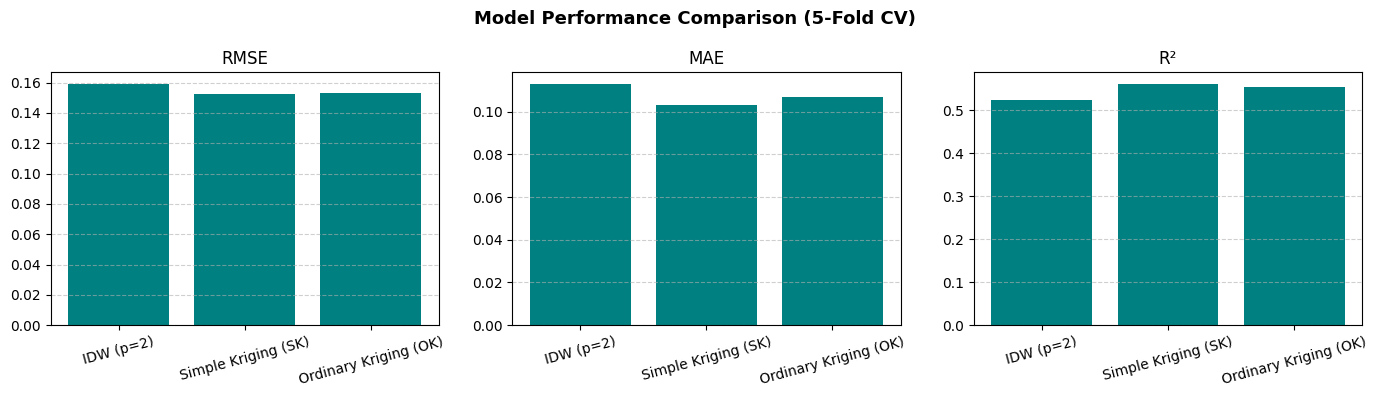

In [ ]:
#Validation & Comparative Analysis (5-Fold Cross-Validation)
from sklearn.model_selection import KFold

print("Running 5-Fold Cross-Validation for IDW, SK, and OK")

# Helper functions
def kfold_cv_idw(df, power=2, n_splits=5):
    preds, obs = [], []
    pts = df[['EAST','NORTH']].values
    vals = df['Cu'].values
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_idx, test_idx in kf.split(df):
        train_pts, test_pts = pts[train_idx], pts[test_idx]
        train_vals, test_vals = vals[train_idx], vals[test_idx]
        p = idw_predict(train_pts, train_vals, test_pts, power=power, radius=search_radius, k=max_neighbors)
        preds.extend(p)
        obs.extend(test_vals)
    return np.array(preds), np.array(obs)

def kfold_cv_ok(df, n_splits=5):
    preds, obs = [], []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_idx, test_idx in kf.split(df):
        train, test = df.iloc[train_idx], df.iloc[test_idx]
        try:
            OKcv = OrdinaryKriging(train['EAST'], train['NORTH'], train['Cu'],
                                   variogram_model='spherical', verbose=False)
            p, _ = OKcv.execute('points', test['EAST'], test['NORTH'])
            preds.extend(p)
            obs.extend(test['Cu'])
        except Exception:
            preds.extend([np.nan]*len(test))
            obs.extend(test['Cu'])
    return np.array(preds), np.array(obs)

def kfold_cv_sk(df, gs_model_local, n_splits=5):
    preds, obs = [], []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_idx, test_idx in kf.split(df):
        train, test = df.iloc[train_idx], df.iloc[test_idx]
        coords_tr = train[['EAST','NORTH']].values
        ns_tr = train['ns_Cu'].values
        try:
            skcv = gs.krige.Simple(gs_model_local,
                                   cond_pos=coords_tr.T,
                                   cond_val=ns_tr,
                                   mean=train['ns_Cu'].mean())
            p_ns = skcv((test['EAST'].values, test['NORTH'].values))[0]
            p_cu = backward_interp(p_ns)
            preds.extend(p_cu)
            obs.extend(test['Cu'])
        except Exception:
            preds.extend([np.nan]*len(test))
            obs.extend(test['Cu'])
    return np.array(preds), np.array(obs)

# Run 5-Fold Cross-Validation for each method
best_p = 2

# IDW
pred_idw, obs_idw = kfold_cv_idw(df, power=best_p)
rmse_idw = np.sqrt(mean_squared_error(obs_idw, pred_idw))
mae_idw = mean_absolute_error(obs_idw, pred_idw)
r2_idw = r2_score(obs_idw, pred_idw)

# OK
pred_ok, obs_ok = kfold_cv_ok(df)
mask_ok = ~np.isnan(pred_ok)
rmse_ok = np.sqrt(mean_squared_error(obs_ok[mask_ok], pred_ok[mask_ok]))
mae_ok = mean_absolute_error(obs_ok[mask_ok], pred_ok[mask_ok])
r2_ok = r2_score(obs_ok[mask_ok], pred_ok[mask_ok])

# SK
pred_sk, obs_sk = kfold_cv_sk(df, gs_model)
mask_sk = ~np.isnan(pred_sk)
rmse_sk = np.sqrt(mean_squared_error(obs_sk[mask_sk], pred_sk[mask_sk]))
mae_sk = mean_absolute_error(obs_sk[mask_sk], pred_sk[mask_sk])
r2_sk = r2_score(obs_sk[mask_sk], pred_sk[mask_sk])


# Compile and visualize results
res_df = pd.DataFrame({
    'Method': [f'IDW (p={best_p})', 'Simple Kriging (SK)', 'Ordinary Kriging (OK)'],
    'RMSE': [rmse_idw, rmse_sk, rmse_ok],
    'MAE': [mae_idw, mae_sk, mae_ok],
    'R²': [r2_idw, r2_sk, r2_ok]
})

print("\nCross-Validation Summary (5-Fold):\n")
print(res_df)
print(f"\nChosen variogram model: {chosen_model_name} (nugget={nugget:.4f}, sill={sill:.4f}, range={vrange:.2f})")

# Plot comparison charts for RMSE, MAE, and R²
metrics = ['RMSE', 'MAE', 'R²']
fig, axs = plt.subplots(1, 3, figsize=(14,4))

for ax, metric in zip(axs, metrics):
    ax.bar(res_df['Method'], res_df[metric], color='teal')
    ax.set_title(metric)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.set_xticklabels(res_df['Method'], rotation=15)

plt.suptitle("Model Performance Comparison (5-Fold CV)", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# 7. Report

# What I did

This week's practical focused on comparing determinstics and geostatistical interpolation methods using the same Copper (Cu%) dataset from Week 3. To ensure traceability, I began by reproducing the foundational steps. The dataset was first declustred using a 50 m cell size to correct for spatial sampling bias. The naive mean Cu% was slightly higher than the declustered mean, confirming that certain dense areas had influenced the overall statistics. The declustered mean was saved as the global mean for Simple Kriging (SK).

Next, the Cu% values were transformed into normal scores using a normal score transform (NST) to approximate a standard normal distribution. This transformation is essential for kriging because it stabilizes variance and makes the data more Gaussian. The variogram of the normal scores was then compared using the same lag parameters as in Week 3. The spherical model was selected as the best fit with parameters of nugget = 0.05, sill = 0.6, and range = 300 m. This model was used consistently for both SK and Ordinary Kriging (OK).

A regular interpolation grid with 10 m spacing was created, covering the spatial extent of the data. The same search neighbourhood was used for all methods, defined as a radius of 1.25 x the variogram range (almost 360 m), with 3 and 16 nearest neighbours.

# What I found
Inverse Distance Weighting (IDW) interpolation was performed for powers p = 1 t0 5. Lower powers (p= 1-2) produced smoother surfaces where each data poiny influenced a broader region, whereas higher powers (p= 4-5) resulted in more localized effects and visible "bullseye" artefacts around individual high-grade samples. IDW with p = 2 achieved a balance between smoothness and spatial detail, making it the most reasonable deterministic choice.

Simple Kriging (SK) produced a smoother map than IDW because it incorporated spatial correlation through the variogram but constrained estimates toward the global mean. The SK variance map showed higher uncertainty in sparsely sampled regions. Ordinary Kriging (OK), which estimates a local mean instead of using a fixed global mean, provided more locally adaptive estimates and slightly sharper transitions between high and low Cu zones. Kriging variance for OK followed the data density pattern, increasing where samples were sparse or far apart.

Cross-validation (using RMSE, MAE, and R2) indicating that OK performed marginally better than SK and IDW, producing lower RMSE and higher correlation between predicted and observed values.

# What it means
Based on the results, Ordinary Kriging (OK) was the most reliable interpolation method for this dataset. It provides a sound statistical basis, produces realistic local variations, and quantifies estimation uncertainty through the kriging variance.

IDW is easy to apply and computationally efficient but lacks the probabilistic rigor of kriging and can exaggerate outlier influence at high powers. Simple Kriging performs well when the global mean is representative but tends to smooth out local variations.

A key limitation of this work is the assumption of isotropy, which ignores possible directional continuity in the mineralization. For future improvement, I would include anisotropy modeling in the variogram and apply k-fold cross-validation to obtain more robust model validation and confidence in the final interpolation.